# IMPORTS

In [1]:
from modules.preprocess import *
from modules.utils import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
from umap import UMAP 
from sklearn.cluster import DBSCAN
from sklearn.model_selection import KFold
from collections import Counter
import tensorboard

2024-04-16 12:19:34.961621: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 12:19:35.650592: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 12:19:37.280192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/xavier/anaconda3/envs/ml_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqd

# BUILD DATASET

In [2]:
dataset = build_dataset(path="data", num_samples=-1, rnd_state=10)
dataset = text_edit(dataset, grp_num=False, rm_newline=True, rm_punctuation=True, lowercase=True, lemmatize=False, html_=True, expand=False)

In [3]:
X = [x for x,y in dataset.items() if y['section_1'] in ['actualites', 'sports', 'international', 'arts', 'affaires']]
Y = [x['section_label'] for x in dataset.values() if x['section_1'] in ['actualites', 'sports', 'international', 'arts', 'affaires']]

# 5-FOLD SPLIT

In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = kf.split(X)
splits = [x for x in splits]
train_index, test_index = splits[4]

In [5]:
train_index = np.array([x for x in train_index])
test_index = np.array([x for x in test_index])

# GET SPECIFIC FOLD

In [22]:
X_train, X_test, Y_train, Y_test = [], [], [], []

for index in train_index:
    X_train.append(X[index])
    Y_train.append(Y[index])

for index in test_index:
    X_test.append(X[index])
    Y_test.append(Y[index])

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [23]:
subtopics = [dataset[x]['section_2'] if not dataset[x]['section_2'].startswith('20') else dataset[x]['section_1'] for x in X_test]

# LOAD PREDICTED 32-DIMENSIONAL VECTORS

In [7]:
with open('results_0.pkl', 'rb') as file:
    results0 = CPU_Unpickler(file).load()
with open('results_1.pkl', 'rb') as file:
    results1 = CPU_Unpickler(file).load()
with open('results_2.pkl', 'rb') as file:
    results2 = CPU_Unpickler(file).load()
with open('results_3.pkl', 'rb') as file:
    results3 = CPU_Unpickler(file).load()
with open('results_4.pkl', 'rb') as file:
    results4 = CPU_Unpickler(file).load()

In [8]:
sample, target = [x[0].view(-1).numpy() for x in results4], [x[1] for x in results4]
samples = np.stack(sample)

# TRAIN/TEST SPLIT FOR SVM/LR/MLP TRAINING

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(samples, target, test_size=0.2, random_state = 42)

In [ ]:
svm_model = tune_svm(X_train, Y_train)

In [ ]:
lr_model = tune_logistic_regression(X_train, Y_train)

In [ ]:
mlp_model = tune_mlp(X_train, Y_train)

# INSTANTIATE MODELS WITH BEST HYPERPARAMETERS

In [12]:
svm_model = SVC(probability=True, C=100, degree=5, gamma='scale', kernel='linear', random_state=42) 
lr_model = LogisticRegression(C=10, penalty='l2', solver='liblinear', max_iter=5000, random_state=42)
mlp_model = MLPClassifier(hidden_layer_sizes=(25,50), activation='relu', learning_rate='adaptive', solver='adam', alpha=0.01, max_iter=5000, random_state=42)

# TRAIN AND EVAL MODELS

In [13]:
lr_model.fit(X_train, Y_train)
lr_y_pred = lr_model.predict(X_test)
evaluate(Y_test, lr_y_pred)

Precision:  0.9373567541363538
Recall:  0.9373695198329853
F1_score:  0.9369857535699839
accuracy:  0.9373695198329853


In [14]:
svm_model.fit(X_train, Y_train)
svm_y_pred = svm_model.predict(X_test)
evaluate(Y_test, svm_y_pred)

Precision:  0.9381952729937173
Recall:  0.9384133611691023
F1_score:  0.9381580041732784
accuracy:  0.9384133611691023


In [15]:
mlp_model.fit(X_train, Y_train)
mlp_y_pred = mlp_model.predict(X_test)
evaluate(Y_test, mlp_y_pred)

Precision:  0.9404549875150378
Recall:  0.9405010438413361
F1_score:  0.9402481718522275
accuracy:  0.9405010438413361


# TOPIC-SPECIFIC PERFORMANCE

In [16]:
class_names = {
    0: 'news',
    1: 'sports',
    2: 'business',
    3: 'arts',
    4: 'international'}
pred_list = list(zip(svm_y_pred, Y_test))
for i in set(Y_test):
    filter_pred = [x for x in pred_list if x[0] == i or x[1] == i]
    i_pred = [x[0] for x in filter_pred]
    i_true = [x[1] for x in filter_pred]
    print(f'Class name: {class_names[i]}')
    evaluate(i_true, i_pred)
    print(len(i_true))

Class name: news
Precision:  0.838382888390278
Recall:  0.8480565371024735
F1_score:  0.8431919680559966
accuracy:  0.8480565371024735
283
Class name: sports
Precision:  0.9723514211886305
Recall:  0.9814814814814815
F1_score:  0.9768951194184838
accuracy:  0.9814814814814815
216
Class name: business
Precision:  0.8497191011235955
Recall:  0.8033707865168539
F1_score:  0.8258952010920928
accuracy:  0.8033707865168539
178
Class name: arts
Precision:  0.8961264822134387
Recall:  0.9043478260869565
F1_score:  0.9002183839587056
accuracy:  0.9043478260869565
115
Class name: international
Precision:  0.8764278296988577
Recall:  0.8888888888888888
F1_score:  0.8826143790849672
accuracy:  0.8888888888888888
225


# 2D VISUALIZATION WITH UMAP

/home/xavier/anaconda3/envs/ml_env/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


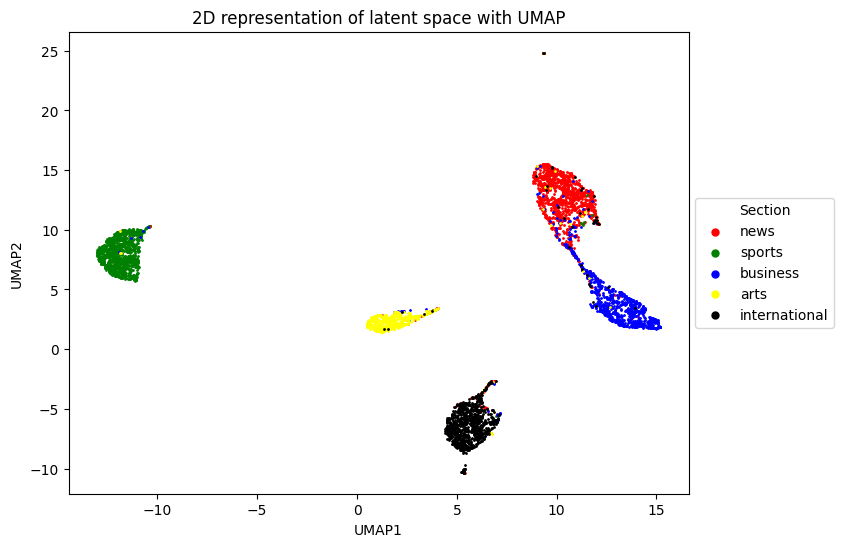

In [17]:
arrays, labels = samples, target

scaler = StandardScaler()
data_scaled = scaler.fit_transform(arrays)

umap_reducer = UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
data_2d = umap_reducer.fit_transform(data_scaled)

fig, ax = plt.subplots(figsize=(8, 6))

colors = {0: 'r', 1: 'g', 2: 'b', 3: 'yellow', 4: 'black'}
class_names = {
    0: 'news',
    1: 'sports',
    2: 'business',
    3: 'arts',
    4: 'international'
}

for label in np.unique(labels):
    ix = np.where(labels == label)
    ax.scatter(data_2d[ix, 0], data_2d[ix, 1], color=colors[label], s=1, label=class_names[label])

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('2D representation of latent space with UMAP')

ax.legend(markerscale=5, loc='center left', bbox_to_anchor=(1, 0.5), title="Section")

plt.savefig('umap_vector_space_2d.png', bbox_inches='tight')  
plt.show()

# SUBTOPIC CLUSTERING WITH DBSCAN

In [ ]:
arrays, labels = samples, target

scaler = StandardScaler()
data_scaled = scaler.fit_transform(arrays)

umap_reducer = UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
data_2d = umap_reducer.fit_transform(data_scaled)

dbscan = DBSCAN(eps=0.3, min_samples=50)
clusters = dbscan.fit_predict(data_2d)

subtopics = [x.replace('justice-et-faits-divers', 'justice') for x in subtopics]
data = list(zip(subtopics, clusters))

cluster_topics = {i: [] for i in np.unique(clusters)}
for topic, cluster in data:
    cluster_topics[cluster].append(topic)

most_common_topics = {}
for cluster, topics in cluster_topics.items():
    topic_count = Counter(topics)
    most_common_topics[cluster] = topic_count.most_common(1)[0][0] if topics else 'No label'

fig, ax = plt.subplots(figsize=(9, 6))

colors = plt.cm.get_cmap('tab10', len([c for c in np.unique(clusters) if c != -1]))  

for cluster_label in np.unique(clusters):
    ix = np.where(clusters == cluster_label)
    if cluster_label != -1: 
        cluster_color = colors(cluster_label)
        ax.scatter(data_2d[ix, 0], data_2d[ix, 1], color=cluster_color, s=1,
                   label=most_common_topics[cluster_label])
    else:
        ax.scatter(data_2d[ix, 0], data_2d[ix, 1], color='lightgrey', s=1) 

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('DBSCAN sub-topic clustering')

legend = ax.legend(markerscale=5, loc='center left', bbox_to_anchor=(1, 0.5), title="Most common topic")

plt.tight_layout()
plt.savefig('dbscan.png', bbox_inches='tight')  

plt.show()

/home/xavier/anaconda3/envs/ml_env/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [21]:
X_test

array([[-0.0236734 ,  0.38309547, -0.01644007, ..., -0.06769201,
        -0.03362734, -1.3692122 ],
       [-0.02247076,  0.20453957, -0.01876942, ..., -0.06536399,
        -0.03568161, -1.596696  ],
       [-0.02268067,  0.269968  , -0.0188555 , ..., -0.06534871,
        -0.03636054, -1.5811828 ],
       ...,
       [-0.02461231,  0.7497529 , -0.01701163, ..., -0.06731163,
        -0.03674374, -1.5744047 ],
       [-0.01922506,  0.90833807, -0.02374152, ..., -0.06063262,
        -0.04440789, -1.4769281 ],
       [-0.02340398,  0.3934687 , -0.01668366, ..., -0.06749591,
        -0.03388142, -1.3678583 ]], dtype=float32)

# TRAIN/TEST LOSS CURVES

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=runs --port=6100